In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import random
import cv2
import numpy as np
!pip install pyefd
import pyefd
from google.colab.patches import cv2_imshow
!pip install cairocffi
import cairocffi as cairo
import struct
from struct import unpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.9 MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89668 sha256=4eac94b129880f623b746d2cd7f2fe4e2dc2d27508f12db847c0199367a064c9
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [ ]:
# Env vars
torch.use_deterministic_algorithms(False)

# Const vars
LOAD_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP raster single.pt'
RAND_SEED = 0
DEVICE = "cuda"

IMG_SIDE = 28
NUM_CLASSES = 343
EPOCHS = 10
BATCH_SIZE = 512
LOSS_FN = nn.CrossEntropyLoss()

In [ ]:
# convert raw vector image to single raster image
def vector_to_raster(vector_image, side=IMG_SIDE, line_diameter=16, padding=96, bg_color=(0,0,0), fg_color=(1,1,1)):
  """
  padding and line_diameter are relative to the original 256x256 image.
  """
  
  original_side = 256.
  
  surface = cairo.ImageSurface(cairo.FORMAT_ARGB32, side, side)
  ctx = cairo.Context(surface)
  ctx.set_antialias(cairo.ANTIALIAS_BEST)
  ctx.set_line_cap(cairo.LINE_CAP_ROUND)
  ctx.set_line_join(cairo.LINE_JOIN_ROUND)
  ctx.set_line_width(line_diameter)

  # scale to match the new size
  # add padding at the edges for the line_diameter
  # and add additional padding to account for antialiasing
  total_padding = padding * 2. + line_diameter
  new_scale = float(side) / float(original_side + total_padding)
  ctx.scale(new_scale, new_scale)
  ctx.translate(total_padding / 2., total_padding / 2.)
      
  bbox = np.hstack(vector_image).max(axis=1)
  offset = ((original_side, original_side) - bbox) / 2.
  offset = offset.reshape(-1,1)
  centered = [stroke + offset for stroke in vector_image]

  # clear background
  ctx.set_source_rgb(*bg_color)
  ctx.paint()

  # draw strokes, this is the most cpu-intensive part
  ctx.set_source_rgb(*fg_color)     
  for xv, yv in centered:   
    ctx.move_to(xv[0], yv[0])
    for x, y in zip(xv, yv):
        ctx.line_to(x, y)
    ctx.stroke()

  data = surface.get_data()
  raster = np.copy(np.asarray(data)[::4]).reshape(28, 28)
  return raster

# Define transformation(s) to be applied to dataset-
transforms_tensor = T.Compose(
      [
          T.ToTensor(), # scales integer inputs in the range [0, 255] into the range [0.0, 1.0] 
      ]
  )

means = np.asarray([[1.00000000e+00,  8.64704953e-20,  4.23785772e-20, -5.55188263e-01],
 [-4.21131398e-03, -8.73318590e-04, -7.46787944e-03, -1.16146910e-02],
 [ 3.45495835e-02, -2.98804448e-04,  1.64286745e-04, -5.45286175e-02],
 [-5.87583192e-06, -2.53474884e-04, -6.50432941e-05,  3.94554346e-03],
 [ 5.82578165e-03, -6.83578601e-04,  1.32397937e-04, -7.64260417e-03],
 [ 3.16973027e-05, -1.02179629e-04, -3.79339444e-04, -4.74683571e-04],
 [ 1.34949896e-03, -1.36386428e-04,  1.15424560e-04, -1.54791375e-03],
 [ 6.86240768e-05, -5.95330926e-05,  3.42253351e-05,  5.09141139e-04],
 [ 1.14870610e-03, -4.14005821e-05,  2.85670771e-05, -5.24566362e-04],
 [ 1.22019705e-04, -8.23679948e-05, -9.08114311e-05, -8.45407870e-05]])

stdevs = np.asarray([[1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.28322956e-01],
 [1.23763294e-01, 1.30004807e-01, 2.44674213e-01, 1.36764044e-01],
 [8.84229438e-02, 6.22169306e-02, 7.98833353e-02, 8.84160503e-02],
 [4.84725535e-02, 4.71595999e-02, 5.60523362e-02, 5.11812694e-02],
 [3.88979383e-02, 3.34160340e-02, 3.58259993e-02, 3.86328886e-02],
 [2.44812410e-02, 2.43872982e-02, 2.82021738e-02, 2.67411865e-02],
 [1.97384502e-02, 1.81130527e-02, 2.00832990e-02, 2.08832311e-02],
 [1.45924819e-02, 1.45891669e-02, 1.58764064e-02, 1.52681562e-02],
 [1.22818532e-02, 1.17304880e-02, 1.22845295e-02, 1.25736286e-02],
 [9.61639517e-03, 9.74633403e-03, 1.03337422e-02, 1.01022058e-02]])

# transform functions - take sketch image, return torch tensor of descriptors
def transform(vector_img, is_test):
  raster = vector_to_raster(vector_img)

  # add rotations and translations at test time
  if is_test: 
    raster = transforms_tensor(raster.astype(np.float32))

    angle = random.random()*60 - 30
    deltaX = random.randint(-3, 3)
    deltaY = random.randint(-3, 3)

    raster = T.functional.affine(raster, angle, [deltaX, deltaY], 1, 0,
                                 interpolation=T.InterpolationMode.BILINEAR)
    raster = np.squeeze(raster.numpy()).astype(np.uint8)
  
  raster_binary = cv2.threshold(raster, 100, 255, cv2.THRESH_BINARY)[1]
  contours, hierarchy = cv2.findContours(raster.astype(np.uint8), 
                                         cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
  largest_size = 0
  largest_index = 0
  for k, contour in enumerate(contours):
      if len(contour) > largest_size:
        largest_size = len(contour)
        largest_index = k

  contour = np.squeeze(contours[largest_index])
  coeffs = pyefd.elliptic_fourier_descriptors(contour, order=FOURIER_ORDER, normalize=True)
  coeffs = (coeffs - means) / stdevs
  return torch.from_numpy(coeffs.flatten()).float()
  

# helper method to find class based on imgset index
def find_class(idx, num_list):
  class_id = 0
  sum = num_list[class_id]
  while idx >= sum:
    class_id += 1
    sum += num_list[class_id]
  return class_id

# deterministic worker re-seeding
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

# custom dataset for quickdraw
class QuickdrawDataset(Dataset):
  def __init__(self, imgs, nums, is_test):
    self.imgs = imgs
    self.nums = nums
    self.len = sum(nums)
    self.is_test = is_test

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    img = self.imgs[idx]
    x = transform(img, self.is_test)
    y = find_class(idx, self.nums)
    return x, y


class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(FOURIER_ORDER * 4, 464)
    self.fc2 = nn.Linear(464, 464)
    self.fc3 = nn.Linear(464, 464)
    self.head = nn.Linear(464, NUM_CLASSES)
    self.relu = nn.ReLU()


  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    return self.head(x)


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # put the model in train mode
    total_loss = 0
    total_correct = 0
    # for each batch in the training set compute loss and update model parameters
    for batch, (x, y) in enumerate(dataloader):
      x, y = x.to(DEVICE), y.to(DEVICE)
      # Compute prediction and loss
      out = model(x)
      loss = loss_fn(out, y)

      # Backpropagation to update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # print current training metrics for user
      y, out, loss = y.to("cpu"), out.to("cpu"), loss.to("cpu")
      loss_val = loss.item()
      if batch % 100 == 0:
          current = (batch + 1) * BATCH_SIZE
          print(f"loss: {loss_val:>7f}  [{current:>5d}/{size:>5d}]")

      pred = out.argmax(dim=1, keepdim=True)
      correct = pred.eq(y.view_as(pred)).sum().item()
      total_correct += correct
      total_loss += loss_val
      # print(f"train loss: {loss_val:>7f}   train accuracy: {correct / BATCH_SIZE:>7f}   [batch: {batch + 1:>3d}/{(size // BATCH_SIZE) + 1:>3d}]")      
    print(f"\nepoch avg train loss: {total_loss / ((size // BATCH_SIZE) + 1):>7f}   epoch avg train accuracy: {total_correct / size:>7f}")
      
def eval_loop(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  with torch.no_grad():
    total_correct = 0
    for x, y in dataloader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      out = model(x)
      y, out = y.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      total_correct += pred.eq(y.view_as(pred)).sum().item()

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")


In [ ]:
# define methods for unpacking Quickdraw .bin files
def unpack_drawing(file_handle):
  file_handle.read(15)
  n_strokes, = unpack('H', file_handle.read(2))
  image = []
  for i in range(n_strokes):
      n_points, = unpack('H', file_handle.read(2))
      fmt = str(n_points) + 'B'
      x = unpack(fmt, file_handle.read(n_points))
      y = unpack(fmt, file_handle.read(n_points))
      image.append((x, y))

  return image


def unpack_drawings(filename):
  imageset = []
  with open(filename, 'rb') as f:
      while True:
          try:
              imageset.append(unpack_drawing(f))
          except struct.error:
              break
  return imageset

train_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Train/'
test_dir = '/content/drive/My Drive/Fourier/Quickdraw Dataset Small/Test/'
train_imgs = []
test_imgs = []
train_nums = []
test_nums = []
list_of_classes = ["The Eiffel Tower", "The Great Wall of China", "The Mona Lisa",
                   "aircraft carrier", "airplane", "alarm clock", "ambulance", 
                   "angel", "ant", "anvil", "apple", "arm", "asparagus", "axe", 
                   "backpack", "banana", "bandage", "barn", "baseball bat", 
                   "baseball", "basket", "basketball", "bathtub", "beach", "bear", 
                   "beard", "bed", "bee", "belt", "bench", "bicycle", "binoculars", 
                   "bird", "birthday cake", "blackberry", "blueberry", "book", 
                   "boomerang", "bottlecap", "bowtie", "bracelet", "brain", 
                   "bread", "bridge", "broccoli", "broom", "bucket", "bulldozer", 
                   "bus", "bush", "butterfly", "cactus", "cake", "calculator", 
                   "calendar", "camel", "camera", "camouflage", "campfire", 
                   "candle", "cannon", "canoe", 'car', 'carrot', "castle", "cat", "ceiling fan", 
                   "cell phone", "cello", "chair", "chandelier", "church", 
                   "circle", "clarinet", "clock", "cloud", "coffee cup", 
                   "compass", "computer", "cookie", "cooler", "couch", "cow",
                   "crab", "crayon", "crocodile", "crown", "cruise ship", 
                   "cup", "diamond", "dishwasher", "diving board", "dog", 
                   "dolphin", "donut", "door", "dragon", "dresser", "drill", 
                   "drums", "duck", "dumbbell", "ear", "elbow", "elephant", 
                   "envelope", "eraser", "eye", "eyeglasses", "face", "fan",
                   "feather", "fence", "finger", "fire hydrant", "fireplace",
                   "firetruck", "fish", "flamingo", "flashlight", "flip flops", 
                   "floor lamp", "flower", "flying saucer", "foot", "fork", 
                   "frog", "frying pan", "garden hose", "garden", "giraffe", 
                   "goatee", "golf club", "grapes", "grass", "guitar", 
                   "hamburger", "hammer", "hand", "harp", "hat", "headphones", 
                   "hedgehog", "helicopter", "helmet", "hexagon", "hockey puck", 
                   "hockey stick", "horse", "hospital", "hot air balloon", 
                   "hot dog", "hot tub", "hourglass", "house plant", "house", 
                   "hurricane", "ice cream", "jacket", "jail", "kangaroo", 
                   "key", "keyboard", "knee", "knife", "ladder", "lantern", 
                   "laptop", "leaf", "leg", "light bulb", "lighter", "lighthouse",
                   "lightning", "line", "lion", "lipstick", "lobster", "lollipop",
                   "mailbox", "map", "marker", "matches", "megaphone", "mermaid", 
                   "microphone", "microwave", "monkey", "moon", "mosquito", 
                   "motorbike", "mountain", "mouse", "moustache", "mouth", "mug",
                   "mushroom", "nail", "necklace", "nose", "ocean", "octagon", 
                   "octopus", "onion", "oven", "owl", "paint can", "paintbrush", 
                   "palm tree", "panda", "pants", "paper clip", "parachute", 
                   "parrot", "passport", "peanut", "pear", "peas", "pencil", 
                   "penguin", "piano", "pickup truck", "picture frame", "pig", 
                   "pillow", "pineapple", "pizza", "pliers", "police car", 
                   "pond", "pool", "popsicle", "postcard", "potato", 
                   "power outlet", "purse", "rabbit", "raccoon", "radio", 
                   "rain", 'rainbow', 'rake', 'remote control', 'rhinoceros', 
                   'rifle', 'river', 'roller coaster', 'rollerskates', 
                   'sailboat', 'sandwich', 'saw', 'saxophone', 'school bus', 
                   'scissors', 'scorpion', 'screwdriver', 'sea turtle', 
                   'see saw', 'shark', 'sheep', 'shoe', 'shorts', 'shovel', 
                   'sink', 'skateboard', 'skull', 'skyscraper', 'sleeping bag', 
                   'smiley face', 'snail', 'snake', 'snorkel', 'snowflake', 
                   'snowman', 'soccer ball', 'sock', 'speedboat', 'spider', 
                   'spoon', 'spreadsheet', 'square', 'squiggle', 'squirrel', 
                   'stairs', 'star', 'steak', 'stereo', 'stethoscope', 'stitches', 
                   'stop sign', 'stove', 'strawberry', 'streetlight', 
                   'string bean', 'submarine', 'suitcase', 'sun', 'swan', 
                   'sweater', 'swing set', 'sword', 'syringe', 't-shirt', 
                   'table', 'teapot', 'teddy-bear', 'telephone', 'television', 
                   'tennis racquet', 'tent', 'tiger', 'toaster', 'toe', 'toilet', 
                   'tooth', 'toothbrush', 'toothpaste', 'tornado', 'tractor', 
                   'traffic light', 'train', 'tree', 'triangle', 'trombone', 
                   'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 
                   'washing machine', 'watermelon', 'waterslide', 'whale', 
                   'wheel', 'windmill', 'wine bottle', 'wine glass', 'wristwatch', 
                   'yoga', 'zebra', 'zigzag']

In [ ]:
# load dataset
for item in list_of_classes:
  train_folder = train_dir + item + '.bin'
  test_folder = test_dir + item + '.bin'
  train_drawings = unpack_drawings(train_folder)
  train_imgs += train_drawings
  train_nums.append(len(train_drawings))
  test_drawings = unpack_drawings(test_folder)
  test_imgs += test_drawings
  test_nums.append(len(test_drawings))

test accuracy: 0.228692


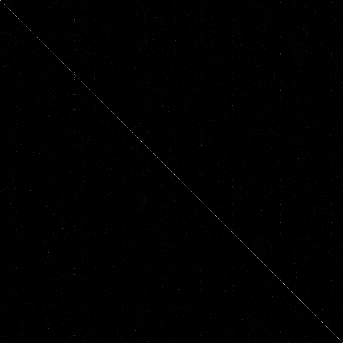

power outlet accuracy 0.0
frog accuracy 0.0
hurricane accuracy 0.0
stereo accuracy 0.0
piano accuracy 0.0
cooler accuracy 0.0
face accuracy 0.0
train accuracy 0.0
camouflage accuracy 0.0
dog accuracy 0.0
aircraft carrier accuracy 0.0
oven accuracy 0.0
hot tub accuracy 0.01
blackberry accuracy 0.01
blueberry accuracy 0.01
peas accuracy 0.01
beard accuracy 0.01
bottlecap accuracy 0.01
pool accuracy 0.01
map accuracy 0.01
bracelet accuracy 0.01
compass accuracy 0.01
The Great Wall of China accuracy 0.01
sandwich accuracy 0.01
truck accuracy 0.01
bush accuracy 0.01
trombone accuracy 0.01
The Mona Lisa accuracy 0.02
toaster accuracy 0.02
drums accuracy 0.02
hospital accuracy 0.02
bread accuracy 0.02
picture frame accuracy 0.02
spreadsheet accuracy 0.02
grass accuracy 0.02
raccoon accuracy 0.02
bird accuracy 0.02
passport accuracy 0.02
firetruck accuracy 0.02
monkey accuracy 0.03
fireplace accuracy 0.03
garden accuracy 0.03
dragon accuracy 0.03
bear accuracy 0.03
roller coaster accuracy 0.03

In [ ]:
FOURIER_ORDER = 20
DEVICE = "cpu"
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)
g = torch.Generator()
g.manual_seed(RAND_SEED)

def get_confusion_mat(dataloader, model):
  model.eval()
  size = len(dataloader.dataset)
  conf_mat = np.zeros((343, 343))
  with torch.no_grad():
    total_correct = 0
    for x, y in dataloader:
      x, y = x.to(DEVICE), y.to(DEVICE)
      out = model(x)
      y, out = y.to("cpu"), out.to("cpu")
      pred = out.argmax(dim=1, keepdim=True)
      y = y.view_as(pred)
      total_correct += pred.eq(y).sum().item()
      y, pred = y.numpy(), pred.numpy()
      indices = np.concatenate((y, pred), axis=1)
      for i in range(indices.shape[0]):
        conf_mat[indices[i, 0], indices[i, 1]] += 1

    accuracy = total_correct / size
    print(f"test accuracy: {accuracy:>7f}")
    return conf_mat

eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

model = MLP()
checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)

random.seed(RAND_SEED)
conf_mat = get_confusion_mat(dataloader=eval_loader,model=model)
conf_mat_norm = conf_mat * (255 / 100)
cv2_imshow(conf_mat_norm)

diag = np.diagonal(conf_mat)
sums = np.asarray(test_nums)
accuracies = diag / sums
acc_sorted_idxs = np.argsort(accuracies)
for i in range(343):
  print(list_of_classes[acc_sorted_idxs[i]] + " accuracy " + str(accuracies[acc_sorted_idxs[i]]))

In [ ]:
FOURIER_ORDER = 10

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.001
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP raster singleF10-001.pt'
for i in range(epoch, EPOCHS):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_loader,model=model)




Fourier order is: 10



Epoch 1

loss: 5.837703  [  512/342985]
loss: 4.964589  [51712/342985]
loss: 4.712196  [102912/342985]
loss: 4.296072  [154112/342985]
loss: 4.179374  [205312/342985]
loss: 4.078753  [256512/342985]
loss: 4.078407  [307712/342985]

epoch avg train loss: 4.435343   epoch avg train accuracy: 0.126396

-------------------------------

Epoch 2

loss: 3.935075  [  512/342985]
loss: 3.925090  [51712/342985]
loss: 3.765791  [102912/342985]
loss: 3.880419  [154112/342985]
loss: 3.822949  [205312/342985]
loss: 3.744500  [256512/342985]
loss: 3.873251  [307712/342985]

epoch avg train loss: 3.775570   epoch avg train accuracy: 0.207913

-------------------------------

Epoch 3

loss: 3.662752  [  512/342985]
loss: 3.637859  [51712/342985]
loss: 3.540116  [102912/342985]
loss: 3.569957  [154112/342985]
loss: 3.633565  [205312/342985]
loss: 3.628327  [256512/342985]
loss: 3.517493  [307712/342985]

epoch avg train loss: 3.569210   epoch avg train accuracy: 0.236558

----

In [ ]:
for i in range(10, 20):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_loader,model=model)

Epoch 11

loss: 3.038433  [  512/342985]
loss: 2.857372  [51712/342985]
loss: 3.130282  [102912/342985]
loss: 2.963034  [154112/342985]
loss: 3.153948  [205312/342985]
loss: 2.963496  [256512/342985]
loss: 2.945812  [307712/342985]

epoch avg train loss: 2.999587   epoch avg train accuracy: 0.321043

-------------------------------

Epoch 12

loss: 2.868218  [  512/342985]
loss: 2.798409  [51712/342985]
loss: 3.034791  [102912/342985]
loss: 3.114730  [154112/342985]
loss: 3.013253  [205312/342985]
loss: 2.990588  [256512/342985]
loss: 2.952623  [307712/342985]

epoch avg train loss: 2.956564   epoch avg train accuracy: 0.328385

-------------------------------

Epoch 13

loss: 2.933904  [  512/342985]
loss: 2.768412  [51712/342985]
loss: 2.715753  [102912/342985]
loss: 2.795322  [154112/342985]
loss: 2.876369  [205312/342985]
loss: 2.918758  [256512/342985]
loss: 2.910690  [307712/342985]

epoch avg train loss: 2.916638   epoch avg train accuracy: 0.334458

----------------------------

In [ ]:
FOURIER_ORDER = 20

# seed RNGs
torch.manual_seed(RAND_SEED)
random.seed(RAND_SEED)

# create datasets
train_data = QuickdrawDataset(train_imgs, train_nums, is_test=False)
# eval_data = QuickdrawDataset(test_imgs, test_nums, is_test=False)
test_data = QuickdrawDataset(test_imgs, test_nums, is_test=True)

# create dataloaders
g = torch.Generator()
g.manual_seed(RAND_SEED)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, worker_init_fn=seed_worker, generator=g)
# eval_loader = DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, generator=g)

# init model and optimizer
model = MLP()
# checkpoint = torch.load(LOAD_PATH, map_location=torch.device(DEVICE))
# model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
lr = 0.01
optim = torch.optim.Adam(model.parameters(), lr=lr)
# optim.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
epoch = 0
print("\n\n\nFourier order is: "+str(FOURIER_ORDER)+"\n\n\n")

# train for EPOCHS number of epochs then evaluate on test data with affine transformations
# eval_loop(dataloader=test_loader,model=model)
SAVE_PATH = '/content/drive/My Drive/Fourier/Saved Models/MLP raster single.pt'
for i in range(epoch, 4):
    print("Epoch " + str(i + 1) + "\n")
    train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
    # eval_loop(dataloader=eval_loader,model=model)
    torch.save({
                'epoch': i + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optim.state_dict()
                }, SAVE_PATH)
    print("\n-------------------------------\n")

lr = 0.001
for g in optim.param_groups:
  g['lr'] = lr

for i in range(4, EPOCHS):
  print("Epoch " + str(i + 1) + "\n")
  train_loop(dataloader=train_loader,model=model,loss_fn=LOSS_FN,optimizer=optim)
  # eval_loop(dataloader=eval_loader,model=model)
  torch.save({
              'epoch': i + 1,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optim.state_dict()
              }, SAVE_PATH)
  print("\n-------------------------------\n")
random.seed(RAND_SEED)
eval_loop(dataloader=test_loader,model=model)




Fourier order is: 20



Epoch 1

loss: 5.840259  [  512/342985]
loss: 4.964982  [51712/342985]
loss: 4.788446  [102912/342985]
loss: 4.461012  [154112/342985]
loss: 4.310803  [205312/342985]
loss: 4.234593  [256512/342985]
loss: 4.282795  [307712/342985]

epoch avg train loss: 4.562697   epoch avg train accuracy: 0.098063

-------------------------------

Epoch 2

loss: 4.070742  [  512/342985]
loss: 4.149727  [51712/342985]
loss: 4.005565  [102912/342985]
loss: 4.041099  [154112/342985]
loss: 4.010985  [205312/342985]
loss: 4.062287  [256512/342985]
loss: 4.061603  [307712/342985]

epoch avg train loss: 4.008401   epoch avg train accuracy: 0.166284

-------------------------------

Epoch 3

loss: 3.895553  [  512/342985]
loss: 3.863436  [51712/342985]
loss: 3.803693  [102912/342985]
loss: 3.843551  [154112/342985]
loss: 3.927000  [205312/342985]
loss: 3.979709  [256512/342985]
loss: 3.782709  [307712/342985]

epoch avg train loss: 3.875353   epoch avg train accuracy: 0.187303

----

RuntimeError: ignored

In [ ]:
random.seed(RAND_SEED)
eval_loop(dataloader=test_loader,model=model)

test accuracy: 0.152559
